In [3]:
import pandas as pd
import numpy as np
import re
import nltk
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, GRU, Conv1D, GlobalMaxPooling1D, Dense, Bidirectional, Dropout


In [4]:
# Step 1: Load and Inspect the Data
file_path = 'rct_data.txt'
data = pd.read_csv(file_path, delimiter='\t', header=None, names=['ID', 'Label', 'Year', 'Title', 'Abstract'])

In [5]:
data.head()

,ID,Label,Year,Title,Abstract
0,18439781,0,2011,Two patients subdued with a TASER® device: cas...,"In the United States, an increasing number of ..."
1,18468833,0,2011,A case of Takayasu arteritis causing subclavia...,The American Heart Association website defines...
2,18481181,0,2012,Pathophysiology of hypopituitarism in the sett...,The complex pathophysiology of traumatic brain...
3,18728056,1,2011,"The cardiovascular risk factor, soluble CD40 l...",[BACKGROUND] Soluble CD40 ligand (sCD40L) is a...
4,18790590,0,2011,Horner syndrome due to carotid dissection.,[BACKGROUND] Internal carotid artery dissectio...


In [6]:
# Load necessary NLTK data
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [7]:
 # preprocess the dataset
data.dropna(subset=['Abstract'], inplace=True)

def preprocess_text(comment):
    lemmatizer = WordNetLemmatizer()
    stop_words = set(stopwords.words('english'))

    # Lowercase
    comment = comment.lower()
    # Remove special characters and URLs
    comment = re.sub(r"http\S+|www\S+|https\S+", '', comment, flags=re.MULTILINE)
    comment = re.sub(r'\@\w+|\#', '', comment)
    # Tokenization
    tokens = word_tokenize(comment)
    # Lemmatization and stop word removal
    comment = ' '.join([lemmatizer.lemmatize(word) for word in tokens if word not in stop_words])
    return comment

data['Abstract'] = data['Abstract'].apply(preprocess_text)
X = data['Abstract']
y = data['Label']

In [8]:
# Split the data
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

In [9]:
# Tokenize and pad sequences for LSTM and GRU
tokenizer = Tokenizer(num_words=5000, oov_token='<OOV>')
tokenizer.fit_on_texts(X_train)
word_index = tokenizer.word_index

In [10]:
max_length = 100
trunc_type='post'
padding_type='post'

In [11]:
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_val_seq = tokenizer.texts_to_sequences(X_val)
X_test_seq = tokenizer.texts_to_sequences(X_test)

In [12]:
X_train_padded = pad_sequences(X_train_seq, maxlen=max_length, padding=padding_type, truncating=trunc_type)
X_val_padded = pad_sequences(X_val_seq, maxlen=max_length, padding=padding_type, truncating=trunc_type)
X_test_padded = pad_sequences(X_test_seq, maxlen=max_length, padding=padding_type, truncating=trunc_type)

In [13]:
# Model 1: LSTM
model_lstm = Sequential([
    Embedding(input_dim=5000, output_dim=64, input_length=max_length),
    Bidirectional(LSTM(64)),
    Dense(1, activation='sigmoid')
])
model_lstm.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

model_lstm.fit(X_train_padded, y_train, epochs=5, validation_data=(X_val_padded, y_val), batch_size=32)

Epoch 1/5


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


101/101 ━━━━━━━━━━━━━━━━━━━━ 18s 133ms/step - accuracy: 0.7499 - loss: 0.5419 - val_accuracy: 0.8932 - val_loss: 0.2710
Epoch 2/5
101/101 ━━━━━━━━━━━━━━━━━━━━ 13s 124ms/step - accuracy: 0.9267 - loss: 0.2027 - val_accuracy: 0.9044 - val_loss: 0.2690
Epoch 3/5
101/101 ━━━━━━━━━━━━━━━━━━━━ 20s 122ms/step - accuracy: 0.9651 - loss: 0.1117 - val_accuracy: 0.8978 - val_loss: 0.2805
Epoch 4/5
101/101 ━━━━━━━━━━━━━━━━━━━━ 21s 133ms/step - accuracy: 0.9889 - loss: 0.0438 - val_accuracy: 0.8932 - val_loss: 0.3031
Epoch 5/5
101/101 ━━━━━━━━━━━━━━━━━━━━ 19s 119ms/step - accuracy: 0.9964 - loss: 0.0189 - val_accuracy: 0.8969 - val_loss: 0.3796


In [14]:
# Evaluate LSTM
y_pred_lstm = (model_lstm.predict(X_test_padded) > 0.5).astype("int32")
print("LSTM Test Accuracy:", accuracy_score(y_test, y_pred_lstm))
print("LSTM Test Report:")
print(classification_report(y_test, y_pred_lstm))

34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step
LSTM Test Accuracy: 0.8867041198501873
LSTM Test Report:
              precision    recall  f1-score   support

           0       0.90      0.95      0.93       807
           1       0.82      0.68      0.75       261

    accuracy                           0.89      1068
   macro avg       0.86      0.82      0.84      1068
weighted avg       0.88      0.89      0.88      1068



In [15]:
# Model 2: GRU
model_gru = Sequential([
    Embedding(input_dim=5000, output_dim=64, input_length=max_length),
    Bidirectional(GRU(64)),
    Dense(1, activation='sigmoid')
])
model_gru.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

model_gru.fit(X_train_padded, y_train, epochs=5, validation_data=(X_val_padded, y_val), batch_size=32)

Epoch 1/5


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


101/101 ━━━━━━━━━━━━━━━━━━━━ 20s 151ms/step - accuracy: 0.7399 - loss: 0.5602 - val_accuracy: 0.8229 - val_loss: 0.3877
Epoch 2/5
101/101 ━━━━━━━━━━━━━━━━━━━━ 20s 143ms/step - accuracy: 0.8961 - loss: 0.2644 - val_accuracy: 0.8941 - val_loss: 0.3054
Epoch 3/5
101/101 ━━━━━━━━━━━━━━━━━━━━ 20s 142ms/step - accuracy: 0.9703 - loss: 0.0850 - val_accuracy: 0.8932 - val_loss: 0.3123
Epoch 4/5
101/101 ━━━━━━━━━━━━━━━━━━━━ 20s 141ms/step - accuracy: 0.9895 - loss: 0.0319 - val_accuracy: 0.8857 - val_loss: 0.4946
Epoch 5/5
101/101 ━━━━━━━━━━━━━━━━━━━━ 21s 143ms/step - accuracy: 0.9951 - loss: 0.0170 - val_accuracy: 0.8997 - val_loss: 0.4015


In [16]:
# Evaluate GRU
y_pred_gru = (model_gru.predict(X_test_padded) > 0.5).astype("int32")
print("GRU Test Accuracy:", accuracy_score(y_test, y_pred_gru))
print("GRU Test Report:")
print(classification_report(y_test, y_pred_gru))

34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step
GRU Test Accuracy: 0.8745318352059925
GRU Test Report:
              precision    recall  f1-score   support

           0       0.91      0.92      0.92       807
           1       0.75      0.73      0.74       261

    accuracy                           0.87      1068
   macro avg       0.83      0.82      0.83      1068
weighted avg       0.87      0.87      0.87      1068



In [17]:
# Model 3: CNN
model_cnn = Sequential([
    Embedding(input_dim=5000, output_dim=64, input_length=max_length),
    Conv1D(128, 5, activation='relu'),
    GlobalMaxPooling1D(),
    Dense(10, activation='relu'),
    Dense(1, activation='sigmoid')
])
model_cnn.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

model_cnn.fit(X_train_padded, y_train, epochs=10, validation_data=(X_val_padded, y_val), batch_size=32)

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


101/101 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - accuracy: 0.7492 - loss: 0.5492 - val_accuracy: 0.9053 - val_loss: 0.3228
Epoch 2/10
101/101 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - accuracy: 0.9212 - loss: 0.2841 - val_accuracy: 0.9372 - val_loss: 0.1847
Epoch 3/10
101/101 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - accuracy: 0.9559 - loss: 0.1262 - val_accuracy: 0.9316 - val_loss: 0.1879
Epoch 4/10
101/101 ━━━━━━━━━━━━━━━━━━━━ 6s 34ms/step - accuracy: 0.9795 - loss: 0.0718 - val_accuracy: 0.9297 - val_loss: 0.2233
Epoch 5/10
101/101 ━━━━━━━━━━━━━━━━━━━━ 4s 36ms/step - accuracy: 0.9935 - loss: 0.0314 - val_accuracy: 0.9297 - val_loss: 0.2874
Epoch 6/10
101/101 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - accuracy: 0.9965 - loss: 0.0216 - val_accuracy: 0.9269 - val_loss: 0.3097
Epoch 7/10
101/101 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - accuracy: 0.9981 - loss: 0.0107 - val_accuracy: 0.9325 - val_loss: 0.2633
Epoch 8/10
101/101 ━━━━━━━━━━━━━━━━━━━━ 4s 39ms/step - accuracy: 0.9993 - loss: 0.0044 - val_accuracy: 0.927

In [18]:
# Evaluate CNN
y_pred_cnn = (model_cnn.predict(X_test_padded) > 0.5).astype("int32")
print("CNN Test Accuracy:", accuracy_score(y_test, y_pred_cnn))
print("CNN Test Report:")
print(classification_report(y_test, y_pred_cnn))

34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
CNN Test Accuracy: 0.9129213483146067
CNN Test Report:
              precision    recall  f1-score   support

           0       0.91      0.98      0.94       807
           1       0.92      0.70      0.80       261

    accuracy                           0.91      1068
   macro avg       0.92      0.84      0.87      1068
weighted avg       0.91      0.91      0.91      1068



34/34 ━━━━━━━━━━━━━━━━━━━━ 3s 84ms/step
34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 53ms/step
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


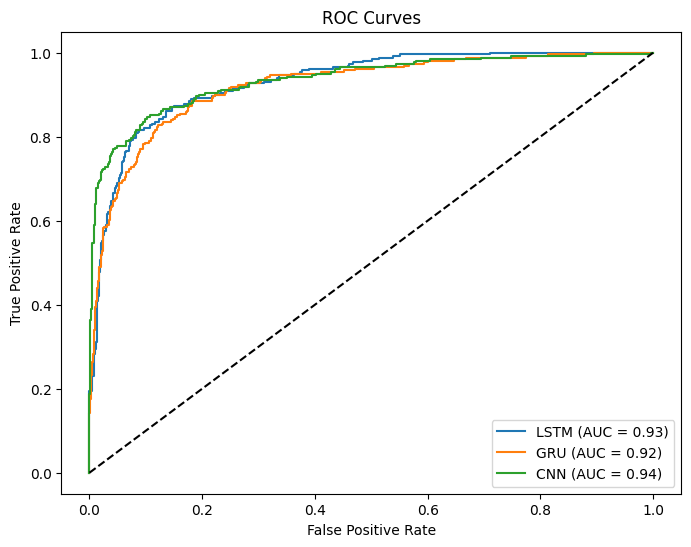

In [19]:

from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Get predicted probabilities for each model
y_pred_prob_lstm = model_lstm.predict(X_test_padded)
y_pred_prob_gru = model_gru.predict(X_test_padded)
y_pred_prob_cnn = model_cnn.predict(X_test_padded)

# Calculate ROC curves
fpr_lstm, tpr_lstm, thresholds_lstm = roc_curve(y_test, y_pred_prob_lstm)
fpr_gru, tpr_gru, thresholds_gru = roc_curve(y_test, y_pred_prob_gru)
fpr_cnn, tpr_cnn, thresholds_cnn = roc_curve(y_test, y_pred_prob_cnn)

# Calculate AUC scores
auc_lstm = auc(fpr_lstm, tpr_lstm)
auc_gru = auc(fpr_gru, tpr_gru)
auc_cnn = auc(fpr_cnn, tpr_cnn)

# Plot ROC curves
plt.figure(figsize=(8, 6))
plt.plot(fpr_lstm, tpr_lstm, label=f'LSTM (AUC = {auc_lstm:.2f})')
plt.plot(fpr_gru, tpr_gru, label=f'GRU (AUC = {auc_gru:.2f})')
plt.plot(fpr_cnn, tpr_cnn, label=f'CNN (AUC = {auc_cnn:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves')
plt.legend(loc='lower right')
plt.show()

In [20]:
from sklearn.metrics import precision_score, recall_score, f1_score

# Calculate precision, recall, and F1-score for each model
precision_lstm = precision_score(y_test, y_pred_lstm)
recall_lstm = recall_score(y_test, y_pred_lstm)
f1_lstm = f1_score(y_test, y_pred_lstm)

precision_gru = precision_score(y_test, y_pred_gru)
recall_gru = recall_score(y_test, y_pred_gru)
f1_gru = f1_score(y_test, y_pred_gru)

precision_cnn = precision_score(y_test, y_pred_cnn)
recall_cnn = recall_score(y_test, y_pred_cnn)
f1_cnn = f1_score(y_test, y_pred_cnn)

# Create a dictionary to store the metrics
metrics = {
    'Model': ['LSTM', 'GRU', 'CNN'],
    'Accuracy': [accuracy_score(y_test, y_pred_lstm), accuracy_score(y_test, y_pred_gru), accuracy_score(y_test, y_pred_cnn)],
    'Precision': [precision_lstm, precision_gru, precision_cnn],
    'Recall': [recall_lstm, recall_gru, recall_cnn],
    'F1-Score': [f1_lstm, f1_gru, f1_cnn],
    'AUC': [auc_lstm, auc_gru, auc_cnn]
}

# Create a pandas DataFrame from the metrics dictionary
df_metrics = pd.DataFrame(metrics)

# Display the DataFrame as a table
print(df_metrics)


  Model  Accuracy  Precision    Recall  F1-Score       AUC
0  LSTM  0.886704   0.824074  0.681992  0.746331  0.931091
1   GRU  0.874532   0.750988  0.727969  0.739300  0.921036
2   CNN  0.912921   0.920000  0.704981  0.798265  0.935749
